In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
import matplotlib
from scipy import ndimage, misc

In [2]:
def make_batch(input_path, label_path, batch_size = 16):
    num_of_data = len(input_path)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_input_path = [input_path[i] for i in index]
    #shuffled_anno_data = [anno_data[j] for j in index]
    shuffled_label_path = [[label_path[j:j+1]][0][0] for j in index]
    #shuffled_anno_data = [anno_data[j:j+1][0][0][0] for j in index]
    
    return np.asarray(shuffled_input_path), np.asarray(shuffled_label_path)

def image_normalize(_input):
    batch_size = np.shape(_input)[0]
    height = np.shape(_input)[1]
    width = np.shape(_input)[2]
    channel = np.shape(_input)[3]
    
    _max_map = [[[[255.0] * channel] * width] * height] * batch_size
    
    output = []

    output = (np.divide(_input, _max_map))
        
    return output

In [4]:
class STN(object):
    def __init__(self, sess, batch_size, epochs):
        self.input_size = 356
        self.output_size = 356
        self.batch_size = batch_size
        self.epochs = epochs
        self.sess = sess
        
        self.initial = np.array([[1., 0., 0.], [0., 1., 0.]], dtype=np.float32)
        self.initial = self.initial.flatten()
        
        self.initial = np.expand_dims(self.initial, axis=0)
        
        self.num_of_conditionmap_channel = 1
        self.num_of_input_channel = 1
        self.num_of_output_channel = 1

        self.X = tf.placeholder(dtype=tf.float32, shape=[None, self.input_size, self.input_size, self.num_of_input_channel])
        self.Y = tf.placeholder(dtype=tf.float32, shape=[None, self.output_size, self.output_size, self.num_of_output_channel])
        self.Condition_Vector = tf.placeholder(dtype = tf.float32, shape = [None, self.input_size, self.input_size, self.num_of_conditionmap_channel])
        #self.Output = tf.placeholder(dtype = tf.float32, shape=[None, self.output_size, self.output_size, 1])
        
        self.W1 = tf.Variable(tf.random_normal(shape=[3, 3, self.num_of_conditionmap_channel + self.num_of_input_channel, 32], stddev=0.01))# 4채널 이유 -> condition vector concat
        self.W2 = tf.Variable(tf.random_normal(shape=[3, 3, 32, 64], stddev=0.01))
        self.W3 = tf.Variable(tf.random_normal(shape=[3, 3, 64, 128], stddev=0.01))
        self.W4 = tf.Variable(tf.random_normal(shape=[3, 3, 128, 256], stddev=0.01))
        self.W5 = tf.Variable(tf.random_normal(shape=[3, 3, 256, 512], stddev=0.01))
        self.W6 = tf.Variable(tf.random_normal(shape=[3, 3, 512, 256], stddev=0.01))
        self.W7 = tf.Variable(tf.random_normal(shape=[3, 3, 256, 128], stddev=0.01))
        self.W8 = tf.Variable(tf.random_normal(shape=[3, 3, 128, 64], stddev=0.01))
        self.W9 = tf.Variable(tf.random_normal(shape=[89*89*64, 32], stddev=0.01))
        self.W10 = tf.Variable(tf.zeros(shape=[32, 6]))
        self.b10 = tf.Variable(self.initial)
        
        
        self.model()
        #self.Get_Pixel_Value()
    
    def Localisation_Net(self, img, condition_vector):
        #img -> [batch, 356, 356, 3]
        img = tf.concat([img, condition_vector], 3)
        
        
        net = tf.nn.conv2d(img, self.W1, padding="SAME", strides=[1, 1, 1, 1])
        net = tf.nn.relu(net)
        net = tf.nn.max_pool(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
        
        #net -> [batch, 178, 178, 32]
        net = tf.nn.conv2d(net, self.W2, padding="SAME", strides=[1, 1, 1, 1])
        net = tf.nn.relu(net)
        net = tf.nn.max_pool(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
        
        #net -> [batch, 89, 89, 64]
        net = tf.nn.conv2d(net, self.W3, padding="SAME", strides=[1, 1, 1, 1])
        net = tf.nn.relu(net)
        
        #net -> [batch, 89, 89, 128]
        net = tf.nn.conv2d(net, self.W4, padding="SAME", strides=[1, 1, 1, 1])
        net = tf.nn.relu(net)
        
        #net -> [batch, 89, 89, 256]
        net = tf.nn.conv2d(net, self.W5, padding="SAME", strides=[1, 1, 1, 1])
        net = tf.nn.relu(net)
        
        #net -> [batch, 89, 89, 128]
        net = tf.nn.conv2d(net, self.W6, padding="SAME", strides=[1, 1, 1, 1])
        net = tf.nn.relu(net)
        
        net = tf.nn.conv2d(net, self.W7, padding="SAME", strides=[1, 1, 1, 1])
        net = tf.nn.relu(net)
        
        net = tf.nn.conv2d(net, self.W8, padding="SAME", strides=[1, 1, 1, 1])
        net = tf.nn.relu(net)
        
        #net -> [batch, 89, 89, 64]
        net = tf.reshape(net, [-1, 89*89*64])
        net = tf.matmul(net, self.W9)
        net = tf.nn.relu(net)
        
        #net -> [batch, 32]
        net = tf.matmul(net, self.W10)
        net = tf.add(net, self.b10)
        
        #net -> [batch, 6]
        theta = net
        return theta
    
        
    def Grid_Generator(self, theta):
        theta = tf.reshape(theta, shape=[-1, 2, 3])
        
        width = self.output_size
        height = self.output_size
        
        x = tf.linspace(-1.0, 1.0, width)
        y = tf.linspace(-1.0, 1.0, height)
        x_t, y_t = tf.meshgrid(x, y)

        # flatten
        x_t_flat = tf.reshape(x_t, [-1])
        y_t_flat = tf.reshape(y_t, [-1])

        # reshape to [x_t, y_t , 1] - (homogeneous form)
        ones = tf.ones_like(x_t_flat)
        sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])

        # repeat grid num_batch times
        sampling_grid = tf.expand_dims(sampling_grid, axis=0)
        sampling_grid = tf.tile(sampling_grid, tf.stack([self.batch_size, 1, 1]))

        # cast to float32 (required for matmul)
        theta = tf.cast(theta, 'float32')
        sampling_grid = tf.cast(sampling_grid, 'float32')

        # transform the sampling grid - batch multiply
        batch_grids = tf.matmul(theta, sampling_grid)
        # batch grid has shape (num_batch, 2, H*W)

        # reshape to (num_batch, H, W, 2)
        batch_grids = tf.reshape(batch_grids, [self.batch_size, 2, height, width])

        return batch_grids
    
    def get_pixel_value(self, img, x, y):
        
        shape = tf.shape(x)
        batch_size = shape[0]
        height = shape[1]
        width = shape[2]

        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, height, width))

        indices = tf.stack([b, y, x], 3)

        return tf.gather_nd(img, indices)
        
    def Bilinear_Sampler(self, img, grid):
        x = grid[:, 0, :, :]
        y = grid[:, 1, :, :]
        
        H = tf.shape(img)[1]
        W = tf.shape(img)[2]
        max_y = tf.cast(H - 1, 'int32')
        max_x = tf.cast(W - 1, 'int32')
        zero = tf.zeros([], dtype='int32')

        # rescale x and y to [0, W-1/H-1]
        x = tf.cast(x, 'float32')
        y = tf.cast(y, 'float32')
        x = 0.5 * ((x + 1.0) * tf.cast(max_x-1, 'float32'))
        y = 0.5 * ((y + 1.0) * tf.cast(max_y-1, 'float32'))

        # grab 4 nearest corner points for each (x_i, y_i)
        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        # clip to range [0, H-1/W-1] to not violate img boundaries
        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        # get pixel value at corner coords
        Ia = self.get_pixel_value(img, x0, y0)
        Ib = self.get_pixel_value(img, x0, y1)
        Ic = self.get_pixel_value(img, x1, y0)
        Id = self.get_pixel_value(img, x1, y1)

        # recast as float for delta calculation
        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        # calculate deltas
        wa = (x1-x) * (y1-y)
        wb = (x1-x) * (y-y0)
        wc = (x-x0) * (y1-y)
        wd = (x-x0) * (y-y0)

        # add dimension for addition
        wa = tf.expand_dims(wa, axis=3)
        wb = tf.expand_dims(wb, axis=3)
        wc = tf.expand_dims(wc, axis=3)
        wd = tf.expand_dims(wd, axis=3)

        # compute output
        out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])

        return out
        
        
    def load_data(self, rot = False, trans = False):
        all_label_img_list = os.listdir("./dataset/Cropped_Resized_Image/")
        all_input_img_list = os.listdir("./dataset/Resized_Image/")
        
        batch_input_img_list, batch_label_img_list = make_batch(all_input_img_list, all_label_img_list, batch_size=self.batch_size)
        
        condition_vector = []
        for i in range(len(batch_input_img_list)):
            if(batch_input_img_list[i][-5] == 'l'):
                tmp = np.ones((356, 356))
                tmp = np.expand_dims(tmp, axis=2)
                condition_vector.append(tmp)
            else:
                tmp = np.zeros((356, 356))
                tmp = np.expand_dims(tmp, axis=2)
                condition_vector.append(tmp)
                
        batch_input_img = []        
        for i in range(len(batch_input_img_list)):
            img = cv2.imread("./dataset/Resized_Image/" + batch_input_img_list[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            batch_input_img.append(img)
            
        batch_label_img = []
        for i in range(len(batch_label_img_list)):
            img = cv2.imread("./dataset/Cropped_Resized_Image/" + batch_label_img_list[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.output_size, self.output_size))
            batch_label_img.append(img)
            
        for i in range(len(batch_input_img)):
            batch_input_img[i] = cv2.normalize(batch_input_img[i], None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            batch_label_img[i] = cv2.normalize(batch_label_img[i], None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        batch_input_img = np.expand_dims(batch_input_img, axis = 3)
        batch_label_img = np.expand_dims(batch_label_img, axis = 3)
        return batch_input_img, batch_label_img, condition_vector
        
    def spatial_transformer(self, _input, condition_vector):
        self.theta = self.Localisation_Net(_input, condition_vector)
        self.grid = self.Grid_Generator(self.theta)
        output = self.Bilinear_Sampler(_input, self.grid)
        
        return output
    
    
    def model(self):
        self.stn_output = self.spatial_transformer(self.X, self.Condition_Vector)
        self.l2_loss = tf.nn.l2_loss((self.stn_output - self.Y) / self.batch_size)
        self.loss = tf.reduce_mean(self.l2_loss)
        
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 3e-05
        lr = tf.train.exponential_decay(starter_learning_rate, global_step,100000, 0.333, staircase=True)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(self.loss, global_step = global_step)
        
    def train(self):
        data_size = 18350
        batch_size = self.batch_size
        total_batch = data_size//batch_size

        loss_data = []
        
        SAVE_PATH = "C:/Users/SimJaekyu/Documents/Jupyter Notebook/Hand_STN/Weight/Weight.ckpt"
        print("session start")
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        try:
            saver.restore(self.sess, SAVE_PATH)
            print("Existing Weight.ckpt file load")
            print("Training Start")
        except:
            print("No Training Weight.ckpt exist")
            print("Make New Weight.ckpt file for training")
            print("Training Start")
        
        loss_data = []
        for epoch in range(self.epochs):#self.epochs):#15
            print("epoch",epoch+1, "start")
            for i in range(total_batch):#total_batch
                #data load, batch 생성
                input_image, label_image, condition_vector = self.load_data()
                
                #print("self.X's shape : ", np.shape(input_image), "self.Y's shape : ", np.shape(label_image), "Condition_Vector's shape : ", np.shape(condition_vector))
                total_loss_opt, net_loss, predict, theta = self.sess.run([self.optimizer, self.l2_loss, self.stn_output, self.theta], feed_dict = {self.X : input_image, self.Y : label_image, self.Condition_Vector : condition_vector})
                loss_data.append(net_loss)
            fig = plt.figure()
            
            print("Theta[0] : ", theta[0])
            
            
            tmp = np.squeeze(input_image[0])
            plt.subplot(131)
            plt.imshow(tmp)
            
            tmp = np.squeeze(predict[0])
            plt.subplot(132)
            plt.imshow(tmp)
            
            tmp = np.squeeze(label_image[0])
            plt.subplot(133)
            plt.imshow(tmp)
            
            fig = matplotlib.pyplot.gcf()
            fig.set_size_inches(12, 4)
            plt.show()
            
            plt.plot(loss_data)
            plt.show()
            print(net_loss)
            saver.save(self.sess, SAVE_PATH)
            
            #return rotate_img, label_img

            
    def demo_test(self):
        data_size = 18350
        batch_size = self.batch_size
        total_batch = data_size//batch_size

        loss_data = []
        
        SAVE_PATH = "C:/Users/SimJaekyu/Documents/Jupyter Notebook/Hand_STN/Weight/Weight.ckpt"
        print("session start")
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        try:
            saver.restore(self.sess, SAVE_PATH)
            print("Existing Weight.ckpt file load")
        except:
            print("No Training Weight.ckpt exist")


        input_image, label_image, condition_vector = self.load_data()

        #print("self.X's shape : ", np.shape(input_image), "self.Y's shape : ", np.shape(label_image), "Condition_Vector's shape : ", np.shape(condition_vector))
        predict = self.sess.run(self.stn_output, feed_dict = {self.X : input_image, self.Y : label_image, self.Condition_Vector : condition_vector})
                
                
        return input_image, label_image, predict
print("cell end")

cell end


In [5]:
with tf.Session() as sess:
    obj = STN(sess=sess, batch_size=16, epochs=1)
    input_image, label_image, predict = obj.demo_test()

session start
INFO:tensorflow:Restoring parameters from C:/Users/SimJaekyu/Documents/Jupyter Notebook/Hand_STN/Weight/Weight.ckpt
Existing Weight.ckpt file load


In [6]:
index = 1

input_image's shape :  (16, 356, 356, 1)


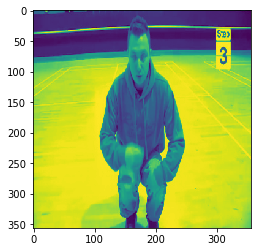

In [8]:
print("input_image's shape : ", np.shape(input_image))
tmp = np.squeeze(input_image[index])
plt.imshow(tmp)
plt.show()

label_image's shape :  (16, 356, 356, 1)


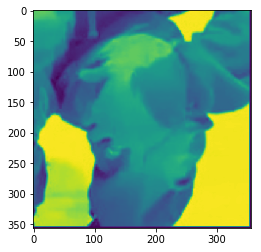

In [9]:
print("label_image's shape : ", np.shape(label_image))
tmp = np.squeeze(label_image[index])
plt.imshow(tmp)
plt.show()

predict's shape :  (16, 356, 356, 1)


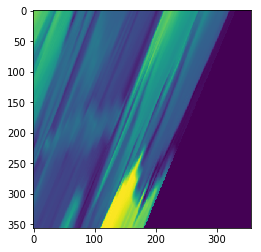

In [11]:
print("predict's shape : ", np.shape(predict))
tmp = np.squeeze(predict[index])
plt.imshow(tmp)
plt.show()

In [20]:
predict[index].max()

147.89581

In [12]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
import matplotlib
from scipy import ndimage, misc

image = cv2.imread("lenacolor512.tiff", cv2.IMREAD_COLOR)  # uint8 image
norm_image = cv2.normalize(image, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

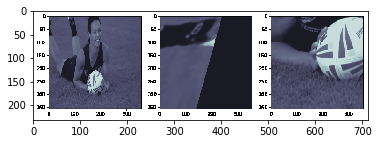

In [17]:

tmp = cv2.imread("./24.png")
tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
plt.imshow(tmp, cmap="bone")
plt.show()